In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl


In [7]:
df = pd.read_csv('./washing-data.csv')
percentage = 0.3
df.head()

,LoadWeight,DirtLevel,FabricType
0,6.3,4,1
1,2.1,2,2
2,4.8,5,1
3,7.5,3,1
4,3.2,1,2


In [8]:
df.describe()

,LoadWeight,DirtLevel,FabricType
count,101.000000,101.000000,101.000000
mean,4.645545,3.019802,1.495050
std,1.932952,1.406984,0.502469
min,1.300000,1.000000,1.000000
25%,3.000000,2.000000,1.000000
50%,4.700000,3.000000,1.000000
75%,6.300000,4.000000,2.000000
max,7.900000,5.000000,2.000000


In [10]:
#Membership Function

load = ctrl.Antecedent(np.linspace(1, 8, 701), 'LoadWeight')
dirt = ctrl.Antecedent(np.linspace(1, 5, 401), 'DirtLevel')
fabric = ctrl.Antecedent(np.linspace(1, 2, 101), 'FabricType')

wash = ctrl.Consequent(np.linspace(15, 90, 751), 'WashTime')
water = ctrl.Consequent(np.linspace(0, 1, 101), 'WaterLevel')
spin = ctrl.Consequent(np.linspace(0, 1, 101), 'SpinSpeed')

# LoadWeight
load['Light'] = fuzz.trimf(load.universe, [1.0, 1.0, 3.0])
load['Medium'] = fuzz.trimf(load.universe, [2.0, 4.5, 7.0])
load['Heavy'] = fuzz.trimf(load.universe, [5.0, 8.0, 8.0])

# DirtLevel
dirt['Low'] = fuzz.trimf(dirt.universe, [1.0, 1.0, 2.0])
dirt['Medium'] = fuzz.trimf(dirt.universe, [1.5, 3.0, 4.5])
dirt['High'] = fuzz.trimf(dirt.universe, [3.5, 5.0, 5.0])

# FabricType
fabric['Normal'] = fuzz.trimf(fabric.universe, [1.0, 1.0, 1.45])
fabric['Delicate'] = fuzz.trimf(fabric.universe, [1.55, 2.0, 2.0])

# WashTime (15-90)
wash['Short'] = fuzz.trimf(wash.universe, [15, 15, 35])
wash['Medium'] = fuzz.trimf(wash.universe, [25, 50, 70])
wash['Long'] = fuzz.trimf(wash.universe, [55, 90, 90])

# WaterLevel
water['Low'] = fuzz.trimf(water.universe, [0.0, 0.0, 0.4])
water['Medium'] = fuzz.trimf(water.universe, [0.25, 0.5, 0.75])
water['High'] = fuzz.trimf(water.universe, [0.6, 1.0, 1.0])

# SpinSpeed
spin['Slow'] = fuzz.trimf(spin.universe, [0.0, 0.0, 0.4])
spin['Medium'] = fuzz.trimf(spin.universe, [0.25, 0.5, 0.75])
spin['Fast'] = fuzz.trimf(spin.universe, [0.6, 1.0, 1.0])

C:\Users\ASUS\.conda\envs\lab_ai\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


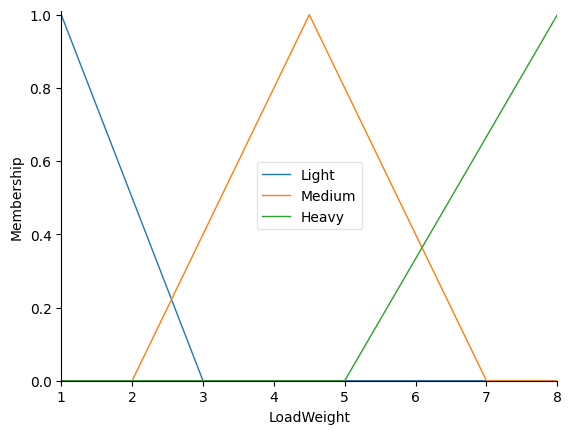

In [11]:
load.view()
plt.show()

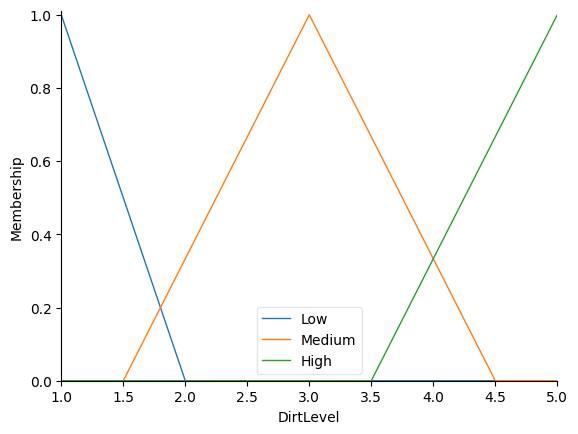

In [12]:
dirt.view()
plt.show()

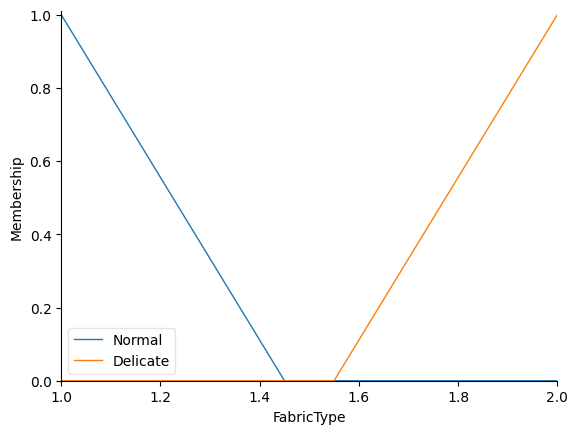

In [13]:
fabric.view()
plt.show()

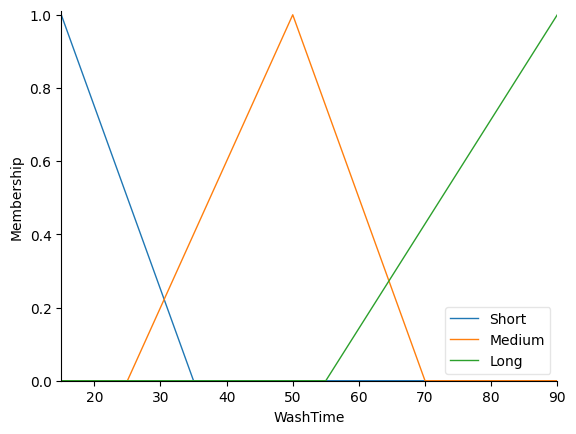

In [14]:
wash.view()
plt.show()

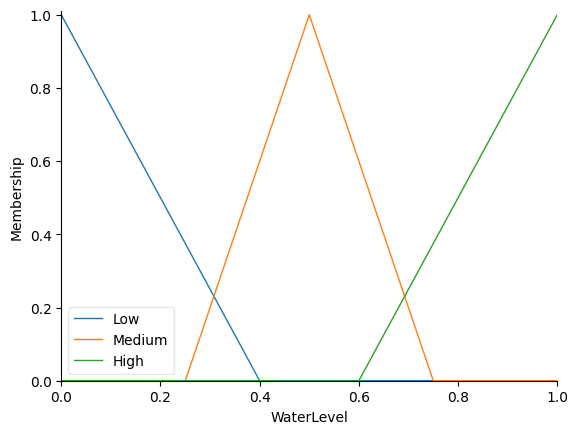

In [15]:
water.view()
plt.show()

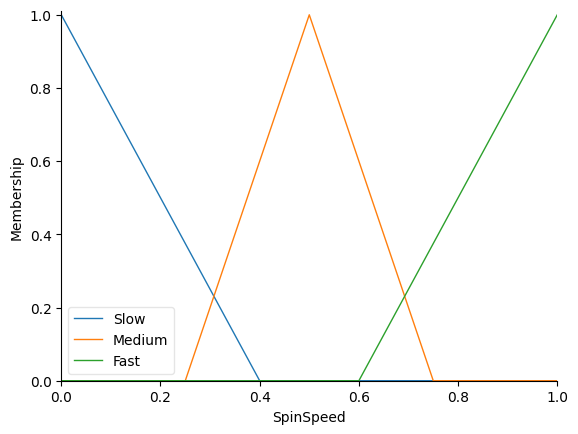

In [16]:
spin.view()
plt.show()

In [19]:
#Rule defenition

rules = []

L = load
D = dirt
F = fabric
W = wash
Wa = water
S = spin

# 1
rules.append(ctrl.Rule(L['Light'] & D['Low'], (W['Short'], Wa['Low'], S['Slow'])))
# 2
rules.append(ctrl.Rule(L['Light'] & D['Medium'], (W['Short'], Wa['Medium'], S['Slow'])))
# 3
rules.append(ctrl.Rule(L['Light'] & D['High'], (W['Medium'], Wa['Medium'], S['Medium'])))

# 4
rules.append(ctrl.Rule(L['Medium'] & D['Low'], (W['Short'], Wa['Medium'], S['Medium'])))
# 5
rules.append(ctrl.Rule(L['Medium'] & D['Medium'], (W['Medium'], Wa['Medium'], S['Medium'])))
# 6
rules.append(ctrl.Rule(L['Medium'] & D['High'], (W['Long'], Wa['High'], S['Fast'])))

# 7
rules.append(ctrl.Rule(L['Heavy'] & D['Low'], (W['Medium'], Wa['High'], S['Medium'])))
# 8
rules.append(ctrl.Rule(L['Heavy'] & D['Medium'], (W['Long'], Wa['High'], S['Fast'])))
# 9
rules.append(ctrl.Rule(L['Heavy'] & D['High'], (W['Long'], Wa['High'], S['Fast'])))

# 10
rules.append(ctrl.Rule(F['Delicate'] & D['Low'], (W['Short'], Wa['Low'], S['Slow'])))
# 11
rules.append(ctrl.Rule(F['Delicate'] & D['Medium'], (W['Medium'], Wa['Medium'], S['Slow'])))
# 12
rules.append(ctrl.Rule(F['Delicate'] & D['High'], (W['Long'], Wa['Medium'], S['Slow'])))

# 13
rules.append(ctrl.Rule(F['Normal'] & L['Heavy'] & D['High'], (W['Long'], Wa['High'], S['Fast'])))
# 14
rules.append(ctrl.Rule(F['Normal'] & L['Light'] & D['Low'], (W['Short'], Wa['Low'], S['Medium'])))

# 15
rules.append(ctrl.Rule(L['Medium'] & F['Delicate'] & D['High'], (W['Medium'], Wa['Medium'], S['Slow'])))
# 16
rules.append(ctrl.Rule(L['Light'] & F['Delicate'] & D['High'], (W['Medium'], Wa['Medium'], S['Slow'])))

# 17
rules.append(ctrl.Rule(L['Heavy'] & F['Delicate'], (W['Long'], Wa['Medium'], S['Slow'])))
# 18
rules.append(ctrl.Rule(D['High'] & F['Normal'], (W['Long'], Wa['High'], S['Fast'])))

In [20]:
#Control System
washing_ctrl = ctrl.ControlSystem(rules)
washing_sim = ctrl.ControlSystemSimulation(washing_ctrl)

In [24]:
def simulate_wash(LoadWeight, DirtLevel, FabricType):
    """
    Run fuzzy inference and return:
      - wash_time (float minutes)
      - water_label (str: Low/Medium/High)
      - spin_label (str: Slow/Medium/Fast)
    FabricType must be 1 (Normal) or 2 (Delicate).
    """
    # set inputs
    washing_sim.input['LoadWeight'] = float(LoadWeight)
    washing_sim.input['DirtLevel'] = float(DirtLevel)
    washing_sim.input['FabricType'] = float(FabricType)

    # compute
    washing_sim.compute()

    # numeric wash time
    wash_time = washing_sim.output['WashTime']

    
    wl_val = None
    sp_val = None
    
    return _derive_outputs_manual(LoadWeight, DirtLevel, FabricType, wash_time)

In [30]:
def _derive_outputs_manual(load_val, dirt_val, fabric_val, wash_time_defuzzed):
    # compute input memberships
    load_m = {
        'Light': fuzz.interp_membership(load.universe, load['Light'].mf, load_val),
        'Medium': fuzz.interp_membership(load.universe, load['Medium'].mf, load_val),
        'Heavy': fuzz.interp_membership(load.universe, load['Heavy'].mf, load_val)
    }
    dirt_m = {
        'Low': fuzz.interp_membership(dirt.universe, dirt['Low'].mf, dirt_val),
        'Medium': fuzz.interp_membership(dirt.universe, dirt['Medium'].mf, dirt_val),
        'High': fuzz.interp_membership(dirt.universe, dirt['High'].mf, dirt_val)
    }
    fabric_m = {
        'Normal': fuzz.interp_membership(fabric.universe, fabric['Normal'].mf, fabric_val),
        'Delicate': fuzz.interp_membership(fabric.universe, fabric['Delicate'].mf, fabric_val)
    }

    # Prepare aggregated membership arrays for water and spin (over their universe)
    agg_water = np.zeros_like(water.universe)
    agg_spin = np.zeros_like(spin.universe)

    # local function to clip and aggregate consequent MF
    def clip_and_agg(target_universe, target_mf, activation, agg_array):
        clipped = np.fmin(activation, target_mf)  # clip consequent MF
        return np.fmax(agg_array, clipped)

    # Evaluate each rule activation and apply to water/spin consequents
    for rule in rules:
        antecedent = rule.antecedent
        pass

    # Determine WaterLevel label
    if (dirt_m['High'] > 0.4 and load_m['Heavy'] > 0.3) or (dirt_m['High'] > 0.7):
        water_label = 'High'
    elif fabric_m['Delicate'] > 0.6:
        water_label = 'Low' if dirt_m['Low'] > 0.2 else 'Medium'
    elif load_m['Light'] > 0.6 and dirt_m['Low'] > 0.5:
        water_label = 'Low'
    else:
        water_label = 'Medium'

    # Determine SpinSpeed label
    if fabric_m['Delicate'] > 0.6:
        spin_label = 'Slow'
    elif (load_m['Heavy'] > 0.5 and dirt_m['High'] > 0.4):
        spin_label = 'Fast'
    elif load_m['Light'] > 0.6 and dirt_m['Low'] > 0.5:
        spin_label = 'Slow'
    else:
        spin_label = 'Medium'

    return float(wash_time_defuzzed), water_label, spin_label

In [28]:
def process_csv(input_path, output_path):
    """
    Reads a CSV with columns: LoadWeight, DirtLevel, FabricType
    Runs fuzzy inference on each row
    Exports a NEW CSV with added columns: WashTime, WaterLevel, SpinSpeed
    """
    df = pd.read_csv(input_path)

    # Check required columns
    required_cols = {'LoadWeight', 'DirtLevel', 'FabricType'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Input CSV must contain columns: {required_cols}")

    results = []
    for _, row in df.iterrows():
        wtime, wlevel, spin_lbl = simulate_wash(row['LoadWeight'], row['DirtLevel'], row['FabricType'])
        results.append([round(wtime, 1), wlevel, spin_lbl])

    df[['WashTime', 'WaterLevel', 'SpinSpeed']] = results
    df.to_csv(output_path, index=False)
    print(f"✅ Processed CSV saved as: {output_path}")


In [29]:
if __name__ == "__main__":
    process_csv("washing-data.csv", "washing_output.csv")

✅ Processed CSV saved as: washing_output.csv
